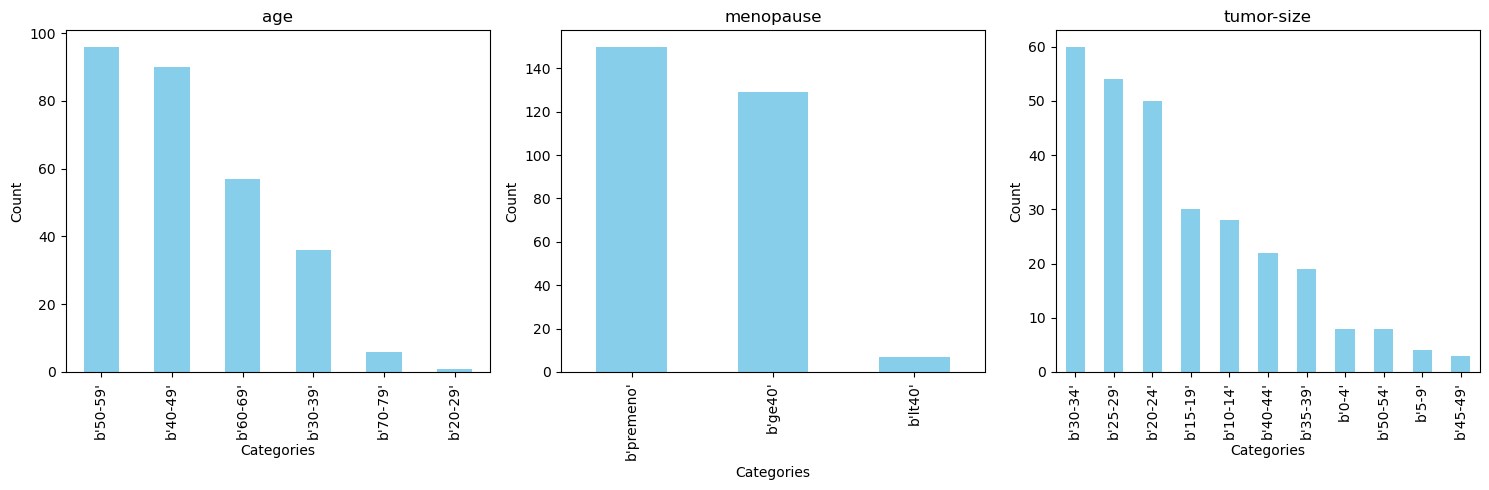

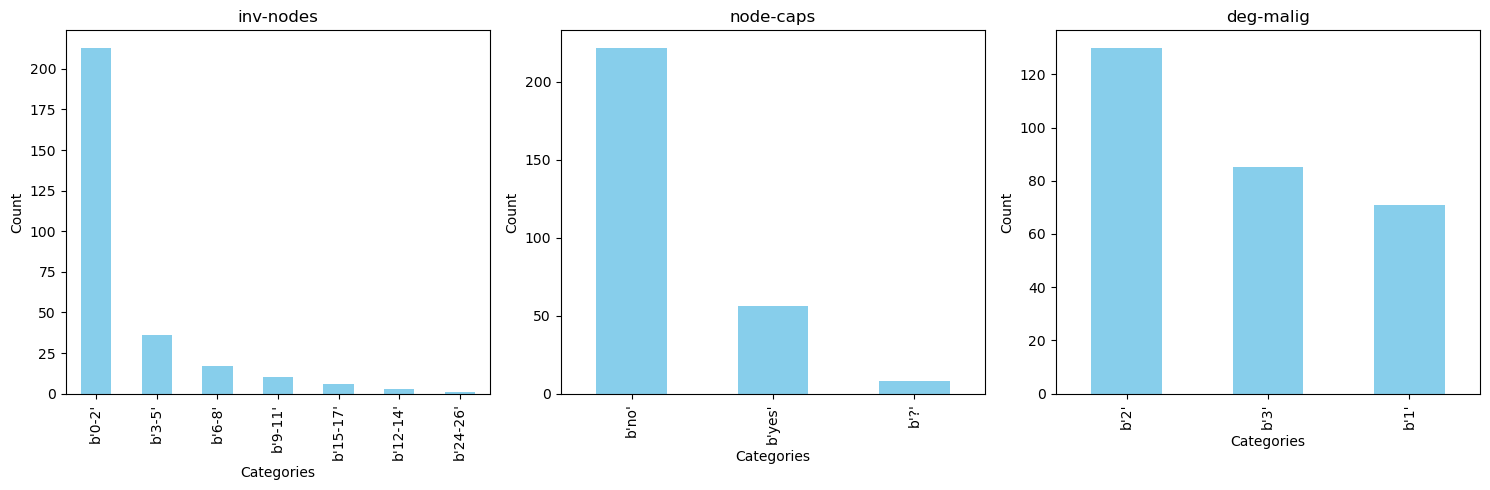

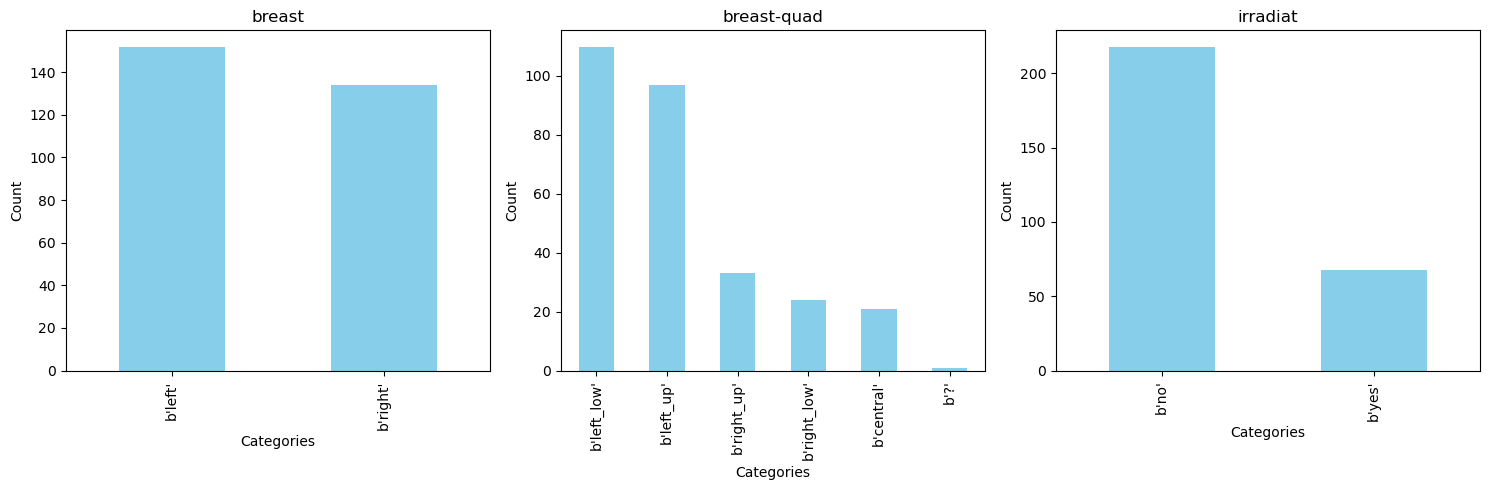

First few rows of the DataFrame:
     age menopause tumor-size inv-nodes node-caps deg-malig breast  \
0  40-49   premeno      15-19       0-2       yes         3  right   
1  50-59      ge40      15-19       0-2        no         1  right   
2  50-59      ge40      35-39       0-2        no         2   left   
3  40-49   premeno      35-39       0-2       yes         3  right   
4  40-49   premeno      30-34       3-5       yes         2   left   

  breast-quad irradiat                 Class  
0     left_up       no     recurrence-events  
1     central       no  no-recurrence-events  
2    left_low       no     recurrence-events  
3    left_low      yes  no-recurrence-events  
4    right_up       no     recurrence-events  

Features and Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menop

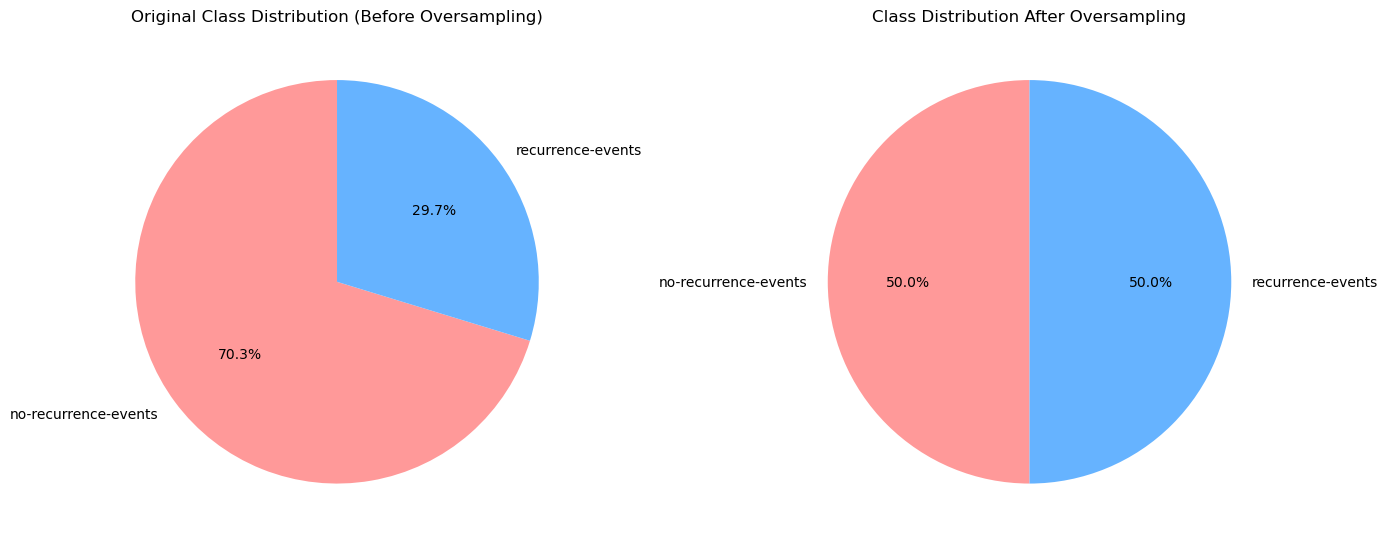


Decision Tree Classifier
Cross-Validation Accuracy Scores: [0.87804878 0.87804878 0.8        0.65       0.95       0.775
 0.75       0.875      0.875      0.8       ]
Mean Accuracy: 0.8231
Standard Deviation: 0.0814

Overall Performance (on the entire dataset):
Accuracy: 0.9850746268656716
Classification Report:
                      precision    recall  f1-score   support

no-recurrence-events       0.99      0.98      0.98       201
   recurrence-events       0.98      1.00      0.99       201

            accuracy                           0.99       402
           macro avg       0.99      0.99      0.99       402
        weighted avg       0.99      0.99      0.99       402

Confusion Matrix:
[[196   5]
 [  1 200]]

Logistic Regression Classifier
Cross-Validation Accuracy Scores: [0.7804878  0.56097561 0.625      0.6        0.725      0.625
 0.65       0.675      0.65       0.375     ]
Mean Accuracy: 0.6266
Standard Deviation: 0.1025

Overall Performance (on the entire dataset):


In [5]:
# Required imports
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample

# Load the ARFF file
data, meta = arff.loadarff('breast-cancer.arff')

# Create a DataFrame
df = pd.DataFrame(data)

import matplotlib.pyplot as plt

# List of feature names (excluding the target variable)
features = df.columns[:-1]  # Exclude the last column, which is assumed to be the target

# Function to plot features in groups
def plot_features_in_groups(features, group_size=3):
    for i in range(0, len(features), group_size):
        group = features[i:i + group_size]  # Select group_size features at a time
        fig, axes = plt.subplots(1, len(group), figsize=(15, 5))  # Create subplots for the group
        
        for j, feature in enumerate(group):
            ax = axes[j]
            df[feature].value_counts().plot(kind='bar', ax=ax, color='skyblue')
            ax.set_title(feature)
            ax.set_xlabel('Categories')
            ax.set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()

# Call the function to plot features
plot_features_in_groups(features, group_size=3)


# Decode byte-string columns if necessary
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Show the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Display basic information about the DataFrame
print("\nFeatures and Data Types:")
print(df.info())

# Show the summary statistics of all columns
print("\nSummary Statistics:")
print(df.describe(include='all'))

# Check the size of the original dataset
print(f"Original Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")

# Check the class distribution in the original dataset
class_distribution = df['Class'].value_counts()
print("\nClass Distribution (Count):")
print(class_distribution)

# Class distribution as percentages
class_distribution_percentage = df['Class'].value_counts(normalize=True) * 100
print("\nClass Distribution (Percentage):")
print(class_distribution_percentage)

import matplotlib.pyplot as plt

# Class distribution before oversampling
original_class_distribution = df['Class'].value_counts()

# Handle missing values (replace "?" with the mode)
df.replace("?", pd.NA, inplace=True)
for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Identify and display missing values
print("Missing Values Before Handling:")
print(df.isnull().sum())  # Check for null/missing values
    
# Separate features and target variable
categorical_columns = df.columns[df.dtypes == 'object'].tolist()
categorical_columns.remove('Class')  # Exclude the target variable

# OneHotEncode categorical features (excluding the target)
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(df[categorical_columns])

# Convert OneHotEncoded features to a DataFrame
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Combine encoded features with the original DataFrame
df = pd.concat([df.drop(columns=categorical_columns), X_encoded_df], axis=1)

# Separate features (X) and target (y)
X = df.drop(columns='Class')
y = df['Class']

# Oversample the minority class by duplicating samples
df_majority = df[df['Class'] == 'no-recurrence-events']
df_minority = df[df['Class'] == 'recurrence-events']

df_minority_oversampled = resample(df_minority,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)

df_balanced = pd.concat([df_majority, df_minority_oversampled])

oversampled_class_distribution = df_balanced['Class'].value_counts()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot original class distribution
ax[0].pie(original_class_distribution, labels=original_class_distribution.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
ax[0].set_title('Original Class Distribution (Before Oversampling)')

# Plot oversampled class distribution
ax[1].pie(oversampled_class_distribution, labels=oversampled_class_distribution.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
ax[1].set_title('Class Distribution After Oversampling')

# Show the plots
plt.tight_layout()
plt.show()

# Update X and y after oversampling
X = df_balanced.drop(columns='Class')
y = df_balanced['Class']

# Normalize and standardize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

standard_scaler = StandardScaler()
X_standardized = standard_scaler.fit_transform(X_normalized)

# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
}

# Perform 10-fold cross-validation and evaluate classifiers
for name, clf in classifiers.items():
    print(f"\n{name} Classifier")
    # Perform cross-validation
    scores = cross_val_score(clf, X_standardized, y, cv=10, scoring='accuracy')
    print(f"Cross-Validation Accuracy Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean():.4f}")
    print(f"Standard Deviation: {scores.std():.4f}")
    
    # Train and evaluate on the entire dataset (for comparison)
    clf.fit(X_standardized, y)
    y_pred = clf.predict(X_standardized)
    print("\nOverall Performance (on the entire dataset):")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Classification Report:")
    print(classification_report(y, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))


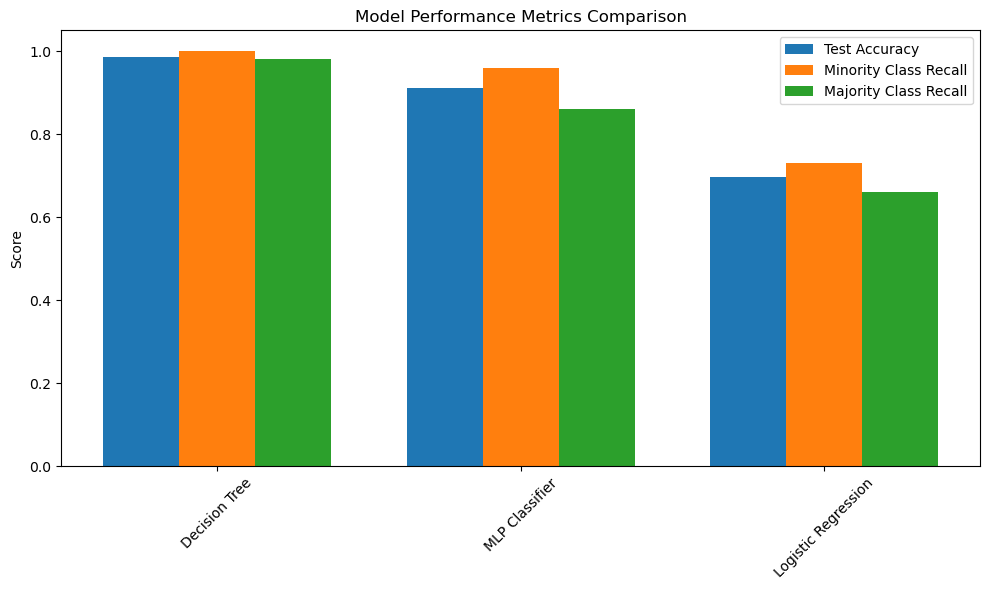

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Models and their metrics
models = ['Decision Tree', 'MLP Classifier', 'Logistic Regression']
test_accuracy = [0.985, 0.91, 0.6965]
minority_class_recall = [1.00, 0.96, 0.73]
majority_class_recall = [0.98, 0.86, 0.66]

# Bar plot
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, test_accuracy, width, label='Test Accuracy', color='#1f77b4')
plt.bar(x, minority_class_recall, width, label='Minority Class Recall', color='#ff7f0e')
plt.bar(x + width, majority_class_recall, width, label='Majority Class Recall', color='#2ca02c')

plt.ylabel('Score')
plt.title('Model Performance Metrics Comparison')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


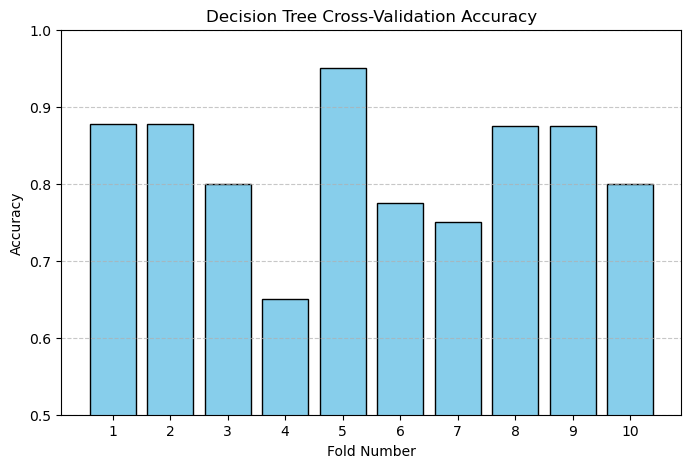

In [5]:


# Cross-validation scores
cv_scores = [0.87804878, 0.87804878, 0.8, 0.65, 0.95, 0.775, 0.75, 0.875, 0.875, 0.8]
folds = np.arange(1, len(cv_scores) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(folds, cv_scores, color='skyblue', edgecolor='black')
plt.xticks(folds)
plt.ylim(0.5, 1.0)
plt.title("Decision Tree Cross-Validation Accuracy")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


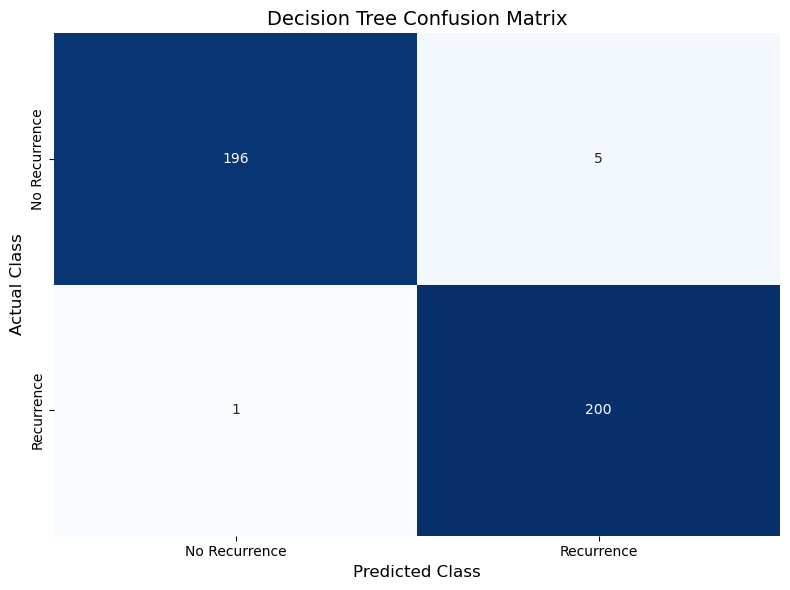

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values
confusion_matrix = np.array([[196, 5],
                              [1, 200]])

# Labels for the heatmap
labels = ['No Recurrence', 'Recurrence']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)

# Add labels and title
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Decision Tree Confusion Matrix', fontsize=14)

# Show the heatmap
plt.tight_layout()
plt.show()


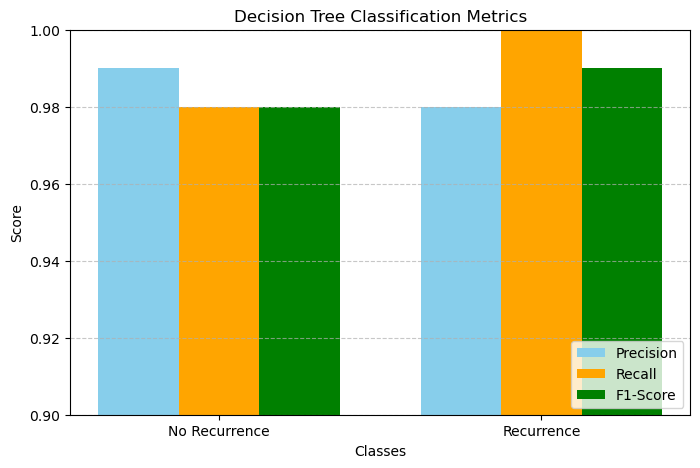

In [7]:
# Classification report metrics
classes = ["No Recurrence", "Recurrence"]
precision = [0.99, 0.98]
recall = [0.98, 1.00]
f1_score = [0.98, 0.99]

x = np.arange(len(classes))  # class positions

# Plotting
width = 0.25
plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width=width, label='Precision', color='skyblue')
plt.bar(x, recall, width=width, label='Recall', color='orange')
plt.bar(x + width, f1_score, width=width, label='F1-Score', color='green')

plt.xticks(x, classes)
plt.ylim(0.9, 1.0)
plt.title("Decision Tree Classification Metrics")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


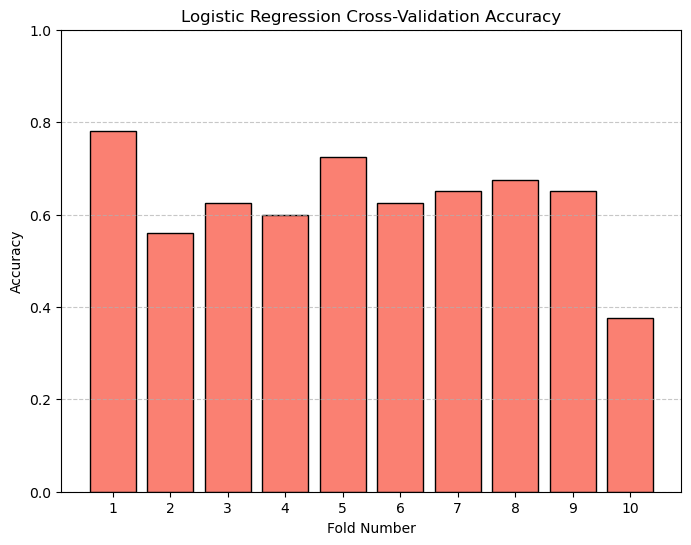

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Cross-validation accuracy scores
log_reg_accuracies = [
    0.7804878, 0.56097561, 0.625, 0.6, 0.725, 0.625, 0.65, 0.675, 0.65, 0.375
]

# Create bar plot
plt.figure(figsize=(8, 6))
folds = np.arange(1, len(log_reg_accuracies) + 1)
plt.bar(folds, log_reg_accuracies, color='salmon', edgecolor='black')
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Cross-Validation Accuracy")
plt.ylim(0, 1)
plt.xticks(folds)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


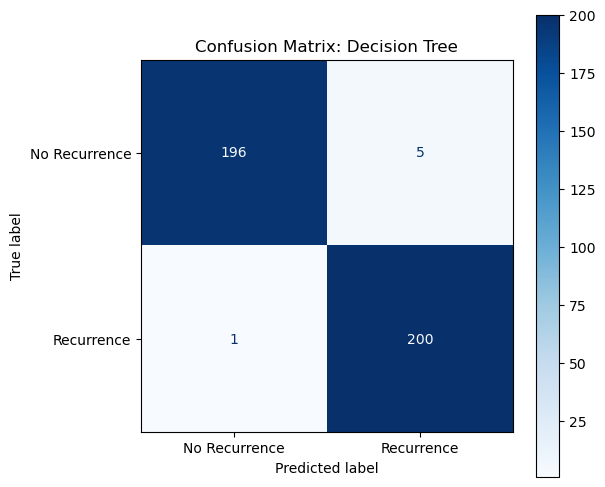

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix data
dt_conf_matrix = np.array([[196, 5], [1, 200]])

# Display confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=dt_conf_matrix, display_labels=["No Recurrence", "Recurrence"])
disp.plot(ax=ax, cmap="Blues")  # Ensure 'Blues' colormap is passed correctly
plt.title("Confusion Matrix: Decision Tree")
plt.show()


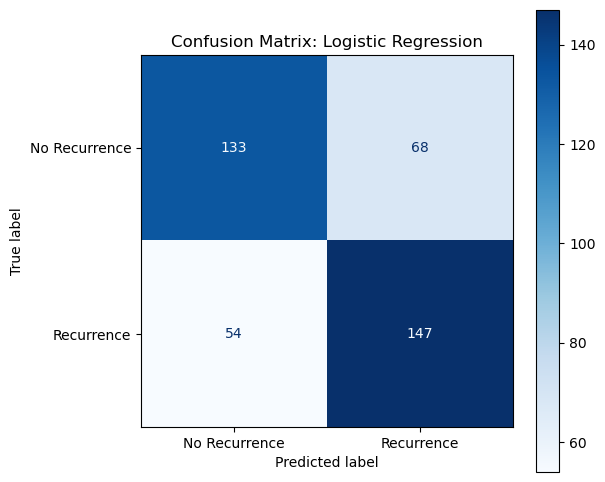

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix data
log_reg_conf_matrix = np.array([[133, 68], [54, 147]])

# Display confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(
    confusion_matrix=log_reg_conf_matrix,
    display_labels=["No Recurrence", "Recurrence"]
).plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression")
plt.show()


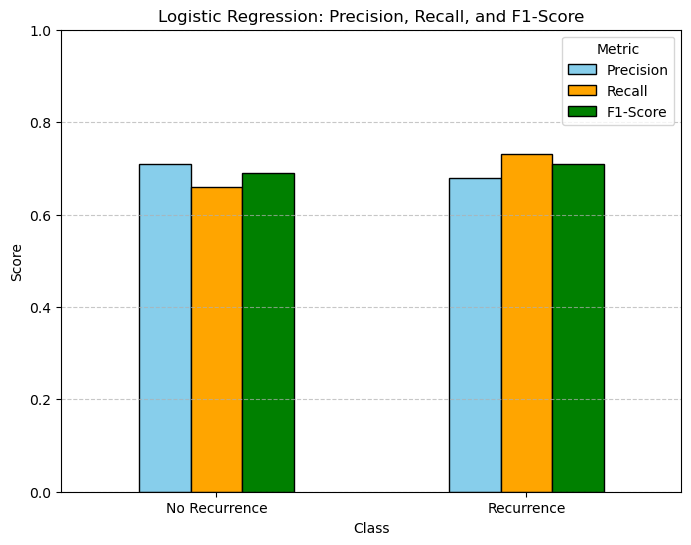

In [10]:
# Logistic Regression classification report metrics
log_reg_metrics = {
    "Class": ["No Recurrence", "Recurrence"],
    "Precision": [0.71, 0.68],
    "Recall": [0.66, 0.73],
    "F1-Score": [0.69, 0.71]
}

# Plotting
import pandas as pd
df = pd.DataFrame(log_reg_metrics)
df.set_index("Class", inplace=True)

df.plot(kind="bar", figsize=(8, 6), color=["skyblue", "orange", "green"], edgecolor="black")
plt.title("Logistic Regression: Precision, Recall, and F1-Score")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Metric")
plt.show()


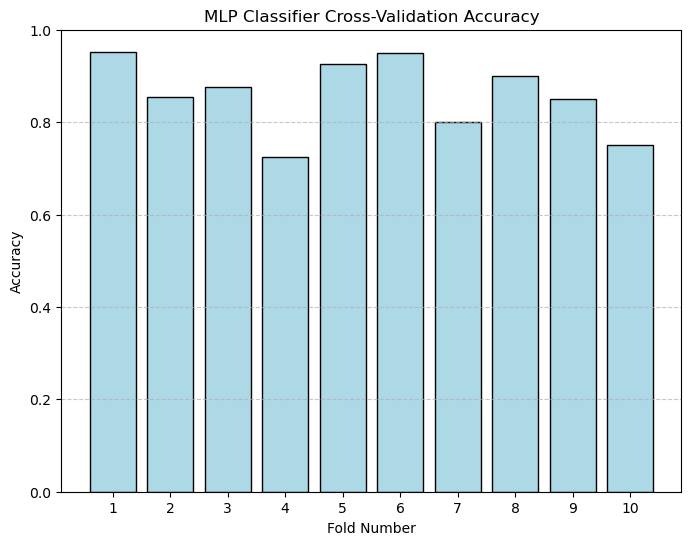

In [5]:
# Cross-validation accuracy scores
nn_accuracies = [
    0.95121951, 0.85365854, 0.875, 0.725, 0.925, 0.95, 0.8, 0.9, 0.85, 0.75
]

# Create bar plot
plt.figure(figsize=(8, 6))
folds = np.arange(1, len(nn_accuracies) + 1)
plt.bar(folds, nn_accuracies, color='lightblue', edgecolor='black')
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("MLP Classifier Cross-Validation Accuracy")
plt.ylim(0, 1)
plt.xticks(folds)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


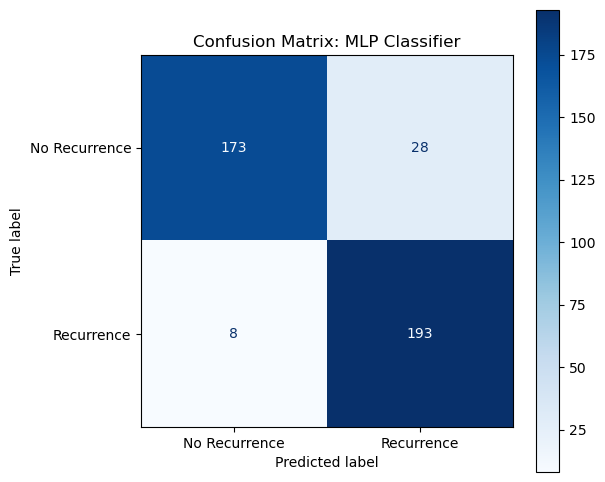

In [6]:
# Confusion matrix data
nn_conf_matrix = np.array([[173, 28], [8, 193]])

# Display confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(
    confusion_matrix=nn_conf_matrix,
    display_labels=["No Recurrence", "Recurrence"]
).plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix: MLP Classifier")
plt.show()


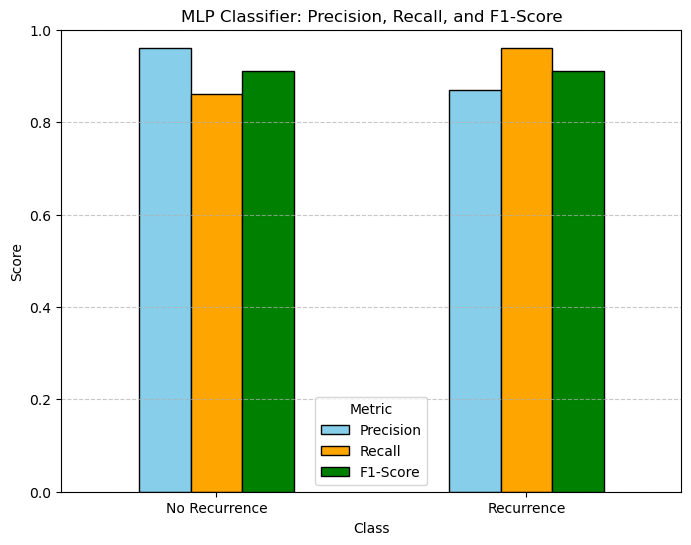

In [7]:
# Neural Network classification report metrics
nn_metrics = {
    "Class": ["No Recurrence", "Recurrence"],
    "Precision": [0.96, 0.87],
    "Recall": [0.86, 0.96],
    "F1-Score": [0.91, 0.91]
}

# Plotting
df_nn = pd.DataFrame(nn_metrics)
df_nn.set_index("Class", inplace=True)

df_nn.plot(kind="bar", figsize=(8, 6), color=["skyblue", "orange", "green"], edgecolor="black")
plt.title("MLP Classifier: Precision, Recall, and F1-Score")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Metric")
plt.show()


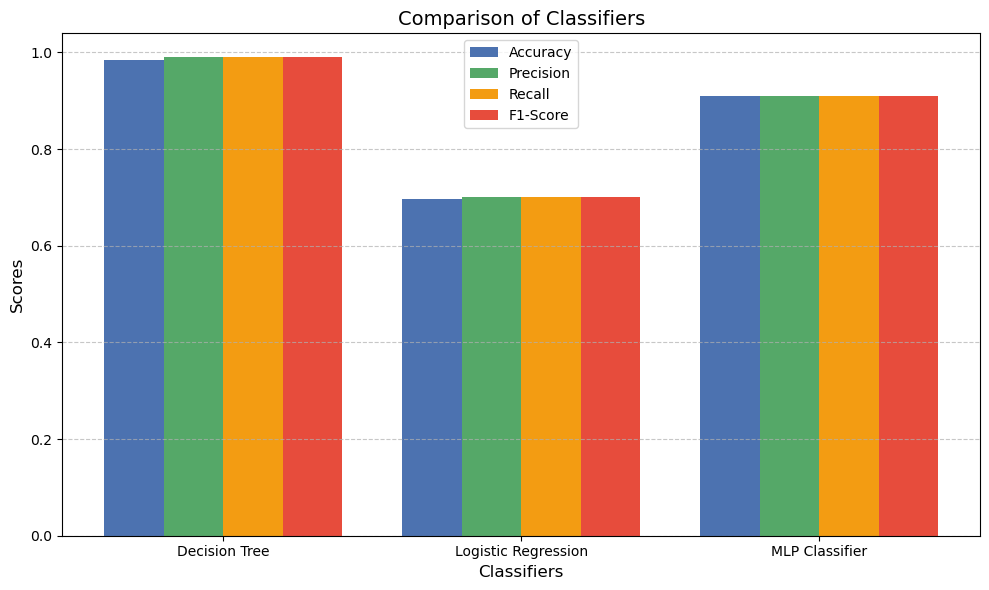

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data for comparison
classifiers = ["Decision Tree", "Logistic Regression", "MLP Classifier"]
accuracy = [0.985, 0.697, 0.910]
precision = [0.99, 0.70, 0.91]
recall = [0.99, 0.70, 0.91]
f1_score = [0.99, 0.70, 0.91]

# Grouped bar chart
x = np.arange(len(classifiers))  # the label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='#4C72B0')
bars2 = ax.bar(x - width/2, precision, width, label='Precision', color='#55A868')
bars3 = ax.bar(x + width/2, recall, width, label='Recall', color='#F39C12')
bars4 = ax.bar(x + width*1.5, f1_score, width, label='F1-Score', color='#E74C3C')

# Add labels, title, and legend
ax.set_xlabel('Classifiers', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Classifiers', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
